# CHEERS Ram-Mohan et al.

**Created**: 25 March 2022

I ran my version of CHEERS on the following set of SNPs. In all cases, I included the lead SNP and any tagging SNPs ($R^2 > 0.8$).

1. Lead eSNPs from Initial cis-eQTL Mapping
2. Conditional eSNPs from cis-eQTL Mapping
3. Conditional eSNPs that represent non-primary signals from the cis-eQTL Mapping
3. Lead eSNPs that are sepsis-specific based on Katie's mashR analysis
4. Lead eSNPs that are sepsis-specific and stronger in GAInS based on Katie's mashR analysis
5. Lead eSNPs that are NOT sepsis-specific based on Katie's mashR analysis

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(patchwork)
library(ComplexHeatmap)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and 

## Specific Stimulations

### Load Data

In [3]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [4]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [5]:
lead.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld.log", sep="\t")

The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`), the number of SNP lists tested (6), and the number of times the testing is done (2).

In [6]:
critical.value <- qnorm(0.05 / (nrow(lead.p.vals) * 6 * 2), lower.tail=F)

In [7]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,62590,581.1033
2,Conditional cis-eQTL,62590,520.6573
3,Conditional Secondary cis-eQTL,62590,905.6683
4,Non-Sepsis-Specific cis-eQTL,62590,636.1226
5,Sepsis-Specific cis-eQTL,62590,1103.1659
6,Sepsis-Specific Up cis-eQTL,62590,1848.8818


In [8]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,LTA,63657.45,Lead cis-eQTL
2,LPS,51387.24,Lead cis-eQTL
3,FLAG,78224.65,Lead cis-eQTL
4,R848,74644.69,Lead cis-eQTL
5,BGP,58160.61,Lead cis-eQTL
6,HMGB1,67782.31,Lead cis-eQTL


In [9]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,LTA,0.03310968,Lead cis-eQTL
2,LPS,1.00000000,Lead cis-eQTL
3,FLAG,0.00000000,Lead cis-eQTL
4,R848,0.00000000,Lead cis-eQTL
5,BGP,1.00000000,Lead cis-eQTL
6,HMGB1,0.00000000,Lead cis-eQTL


### Enrichment of Different SNP Lists

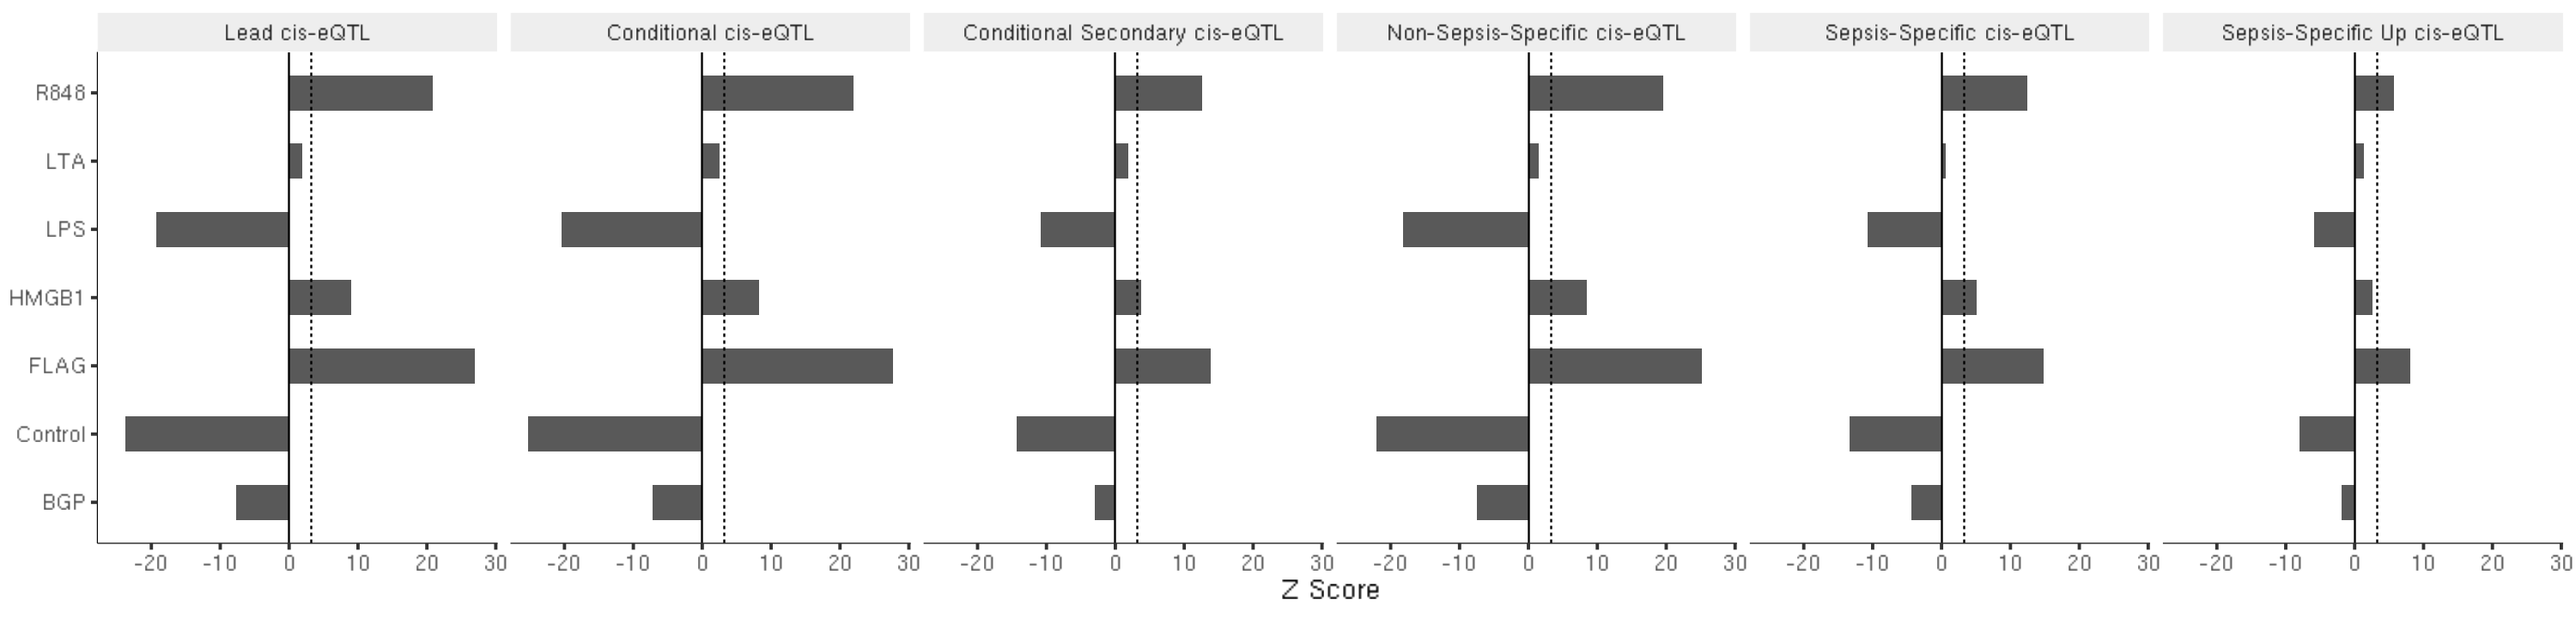

In [10]:
options(repr.plot.width=25, repr.plot.height=6)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", width=0.5) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    geom_hline(aes(yintercept=0)) +
    facet_grid(. ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_ram_mohan_et_al_all.svg", width=25, height=6)

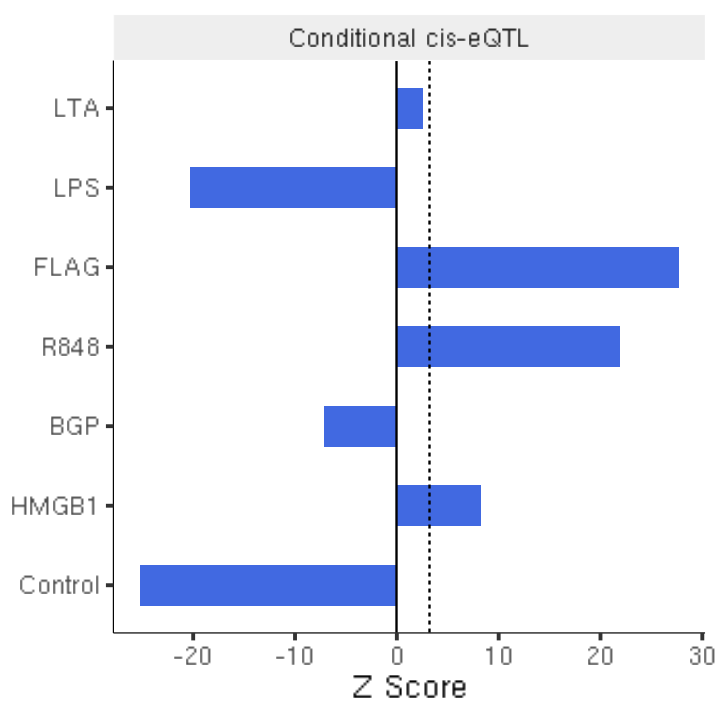

In [11]:
options(repr.plot.width=6, repr.plot.height=6)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs == "Conditional cis-eQTL") %>%
    dplyr::mutate(Condition=factor(Condition, levels=rev(c("LTA", "LPS", "FLAG", "R848", "BGP", "HMGB1", "Control")))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", width=0.5, fill="royalblue") +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    geom_hline(aes(yintercept=0)) +
    facet_grid(. ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_ram_mohan_et_al_conditional.svg", width=6, height=6)

## Whole Organism Stimulation

### Load Data

In [12]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_WB_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
     "~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_WB_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [13]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_WB_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [14]:
lead.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/lead_snps_ld_WB.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_snps_ld_WB.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/conditional_secondary_snps_ld_WB.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/non_sepsis_snps_ld_WB.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_snps_ld_WB.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/enrichment/cheers/sepsis_up_snps_ld_WB.log", sep="\t")

In [15]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL"), #, "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2]), #, sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2]) #, sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,62590,576.0608
2,Conditional cis-eQTL,62590,517.0213
3,Conditional Secondary cis-eQTL,62590,900.0328
4,Non-Sepsis-Specific cis-eQTL,62590,631.0586
5,Sepsis-Specific cis-eQTL,62590,1089.5430


In [16]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,WB,58890.13,Lead cis-eQTL
2,SA-1,51240.65,Lead cis-eQTL
3,SA-3,61352.12,Lead cis-eQTL
4,SA-5,64907.06,Lead cis-eQTL
5,noEC1h,75703.30,Lead cis-eQTL
6,noEC4h,62729.65,Lead cis-eQTL


In [17]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,WB,1.000000e+00,Lead cis-eQTL
2,SA-1,1.000000e+00,Lead cis-eQTL
3,SA-3,9.841777e-01,Lead cis-eQTL
4,SA-5,2.882277e-05,Lead cis-eQTL
5,noEC1h,0.000000e+00,Lead cis-eQTL
6,noEC4h,4.042239e-01,Lead cis-eQTL


### Enrichment of Different SNP Lists

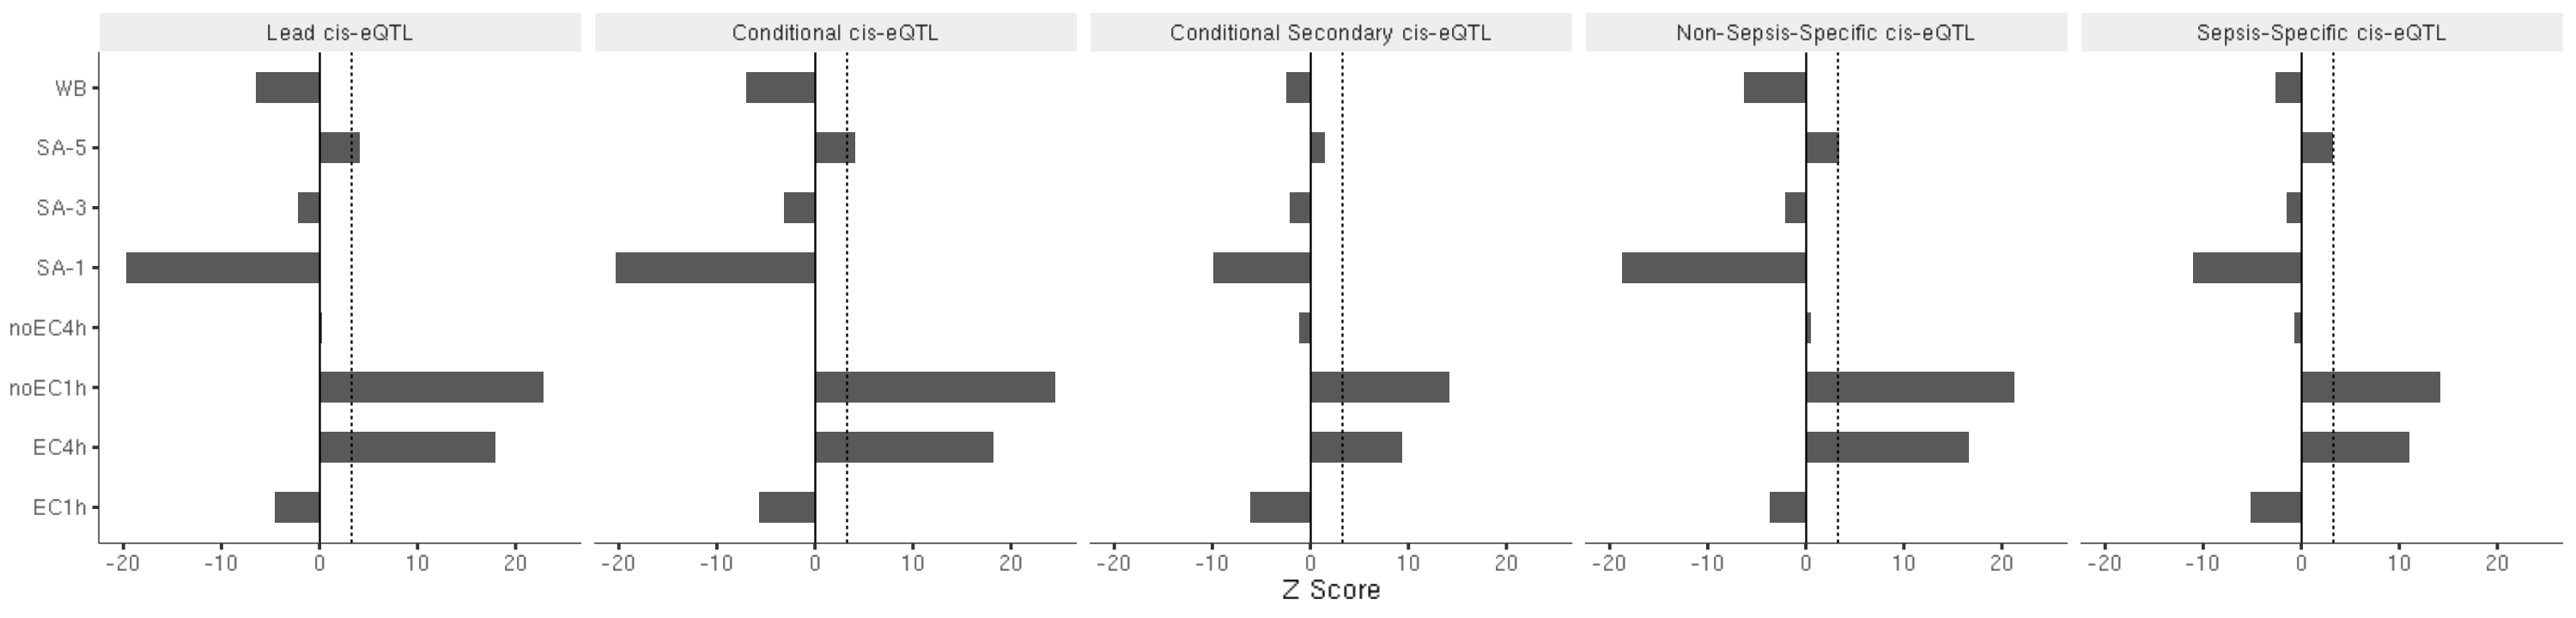

In [18]:
options(repr.plot.width=25, repr.plot.height=6)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", width=0.5) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    geom_hline(aes(yintercept=0)) +
    facet_grid(. ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_ram_mohan_et_all_whole_organism_all.svg", width=25, height=6)

# Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

## Peaks Driving Cell-Type-Specific Enrichment

CHEERS works on cell-type-specificity scores for peaks. We can use these specificity scores to understand which peaks are driving the enrichment signal.

In [19]:
all.norm <- fread("~/gains_team282/epigenetics/enrichment/cheers/normalized/Neutrophil_Atlas_counts_normToMax_quantileNorm_euclideanNorm.txt") %>%
    as.data.frame() %>%
    dplyr::mutate(ID=paste0(chr, ":", start, "-", end))

rownames(all.norm) <- all.norm$ID

In [20]:
head(all.norm)

,chr,start,end,LTA,LPS,FLAG,R848,BGP,HMGB1,Control,ID
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr1:827299-827824,chr1,827299,827824,0.4354,0.2106,0.4345,0.4886,0.2286,0.4108,0.3429,chr1:827299-827824
chr1:869724-870249,chr1,869724,870249,0.3694,0.2963,0.4371,0.5011,0.2182,0.3579,0.3973,chr1:869724-870249
chr1:904489-905014,chr1,904489,905014,0.3922,0.3162,0.4189,0.4371,0.2958,0.3503,0.4117,chr1:904489-905014
chr1:912920-913445,chr1,912920,913445,0.3802,0.3037,0.3379,0.5119,0.4300,0.3431,0.2906,chr1:912920-913445
chr1:913847-914372,chr1,913847,914372,0.3438,0.4614,0.4056,0.3186,0.4314,0.3175,0.3406,chr1:913847-914372
chr1:918649-919174,chr1,918649,919174,0.2993,0.3871,0.3278,0.3939,0.4992,0.3625,0.3424,chr1:918649-919174


In [23]:
all.norm %>%
    dplyr::arrange(desc(FLAG)) %>%
    head()

,chr,start,end,LTA,LPS,FLAG,R848,BGP,HMGB1,Control,ID
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr19:51646821-51647346,chr19,51646821,51647346,0.3195,0.3169,0.6782,0.3145,0.3241,0.3076,0.1972,chr19:51646821-51647346
chr8:79840133-79840658,chr8,79840133,79840658,0.3958,0.2680,0.6719,0.2241,0.3485,0.2632,0.2813,chr8:79840133-79840658
chr10:58448196-58448721,chr10,58448196,58448721,0.2957,0.2861,0.6689,0.2890,0.3194,0.3537,0.2696,chr10:58448196-58448721
chr7:94417437-94417962,chr7,94417437,94417962,0.3259,0.3095,0.6640,0.2828,0.4242,0.2476,0.1893,chr7:94417437-94417962
chr7:74134084-74134609,chr7,74134084,74134609,0.2604,0.2437,0.6621,0.3836,0.2986,0.3808,0.2302,chr7:74134084-74134609
chr9:36728431-36728956,chr9,36728431,36728956,0.3464,0.2560,0.6513,0.3018,0.2991,0.3404,0.3062,chr9:36728431-36728956


In [21]:
plot.data <- all.norm %>%
    tidyr::gather("Condition", "Euclidean.Norm", -ID, -chr, -start, -end) %>%
    dplyr::mutate(Peak.Size = end - start)

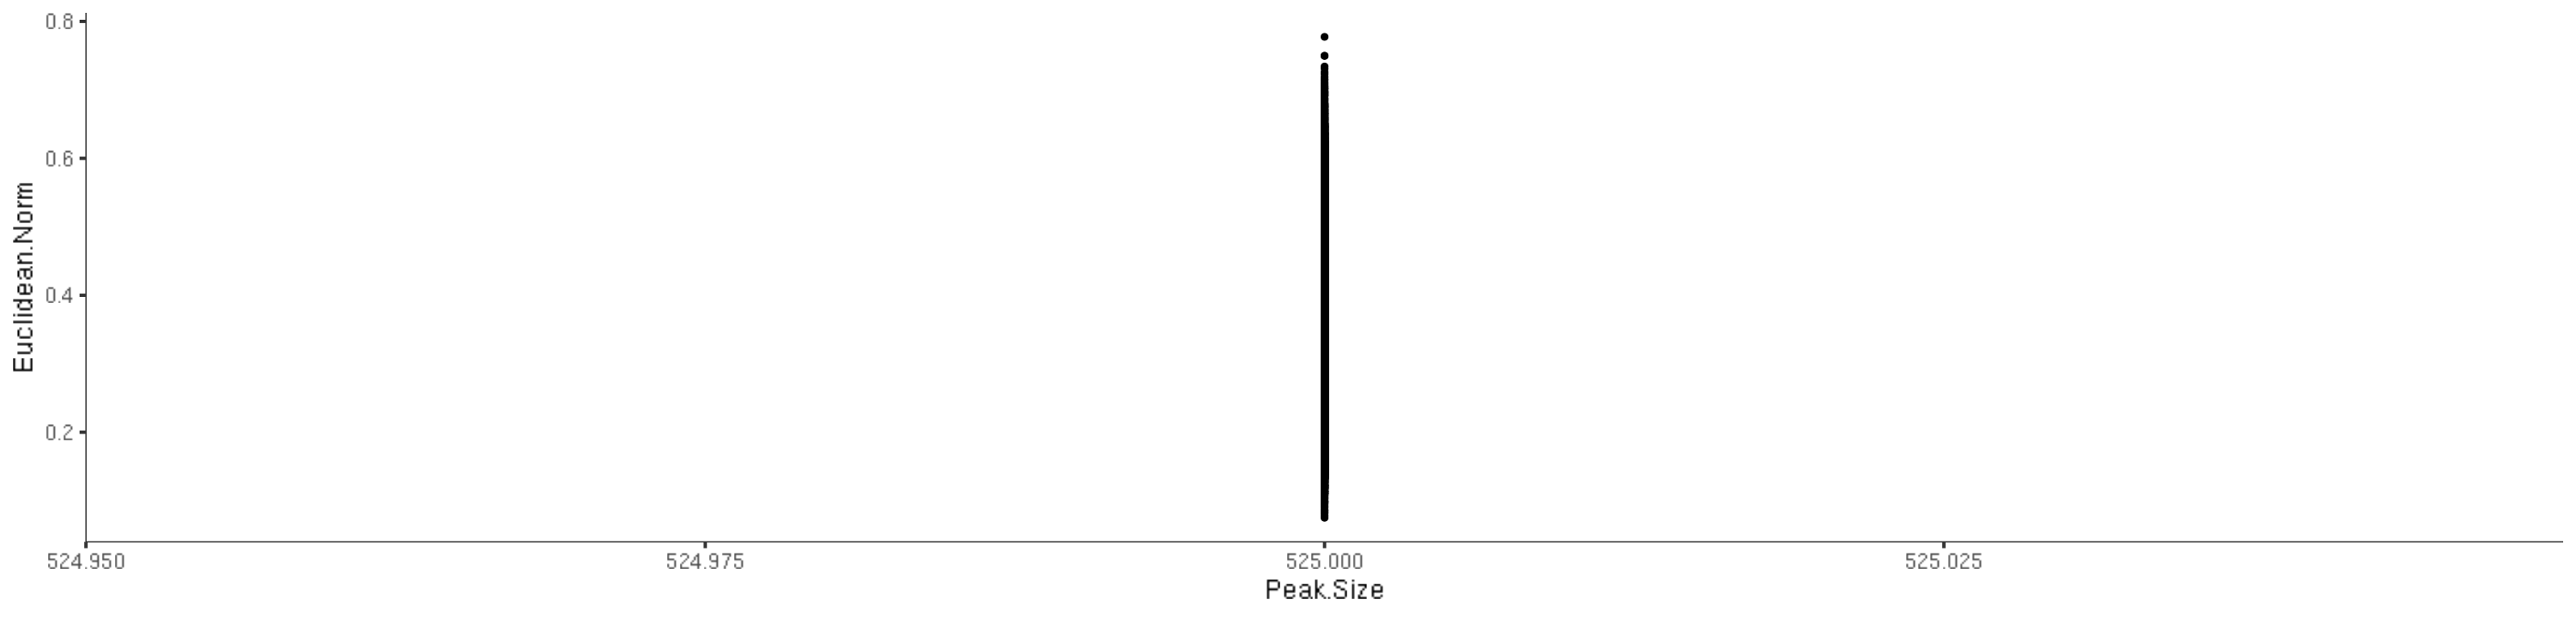

In [22]:
plot.data %>%
    ggplot() +
    geom_point(aes(x=Peak.Size, y=Euclidean.Norm)) +
    ggplot_theme

In [23]:
all.norm %>%
    tidyr::gather("Condition", "Euclidean.Norm", -ID, -chr, -start, -end) %>%
    dplyr::filter(Condition == "FLAG" | Condition == "LPS") %>%
    dplyr::mutate(Peak.Size = end - start) %>%
    ggplot(aes(color=Condition)) +
    geom_point(aes(x=Peak.Size, y=Euclidean.Norm), alpha=0.1) +
    geom_smooth(aes(x=Peak.Size, y=Euclidean.Norm)) +
    ggplot_theme

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

